## How to Create Environment first on your terminal 
1. conda create -n EOG_classification
2. conda activate EOG_classification
3. conda install catboost sklearn scipy numpy pywt

# import libraries

In [1]:
#!conda install catboost
import pandas as pd
from scipy import signal
from scipy import stats
from scipy.signal import butter,filtfilt, sosfiltfilt, lfilter
import matplotlib.pyplot as plt
import numpy as np
# conda install scikit-learn
from sklearn.decomposition import PCA 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pywt  #conda install pywavelets

#from catboost import CatBoostClassifier

# Helper functions

In [2]:
def signal_filter_butterworth(data_col, sr, lowcut, highcut, order=4): #1.5, 15
    """
    Apply butterworth + forward-backward digital filter on a given data column.
    Return np.array of that filtered data.

    :param data_col: np.array. Columns that only contains values from channel of interest. Shape: (500,)
    :param sr : int. Sampling Frequency (Hz)
    :param low_cut : float
    :param highcut : float
    :param order : int. Order of the filter
    """
    sos = butter(order, [lowcut, highcut], btype="bandpass", output="sos", fs=sr)
    filtered = sosfiltfilt(sos, data_col)
    return filtered

def butter_bandpass_filter(input,low_cutoff,high_cutoff,sampling_rate,order):
  nyq=0.5*sampling_rate
  low=low_cutoff/nyq
  high=high_cutoff/nyq
  numerator,denominator=butter(order,[low,high],btype='band',output='ba',analog=False,fs=None)
  filterd=filtfilt(numerator,denominator,input)
  return filterd


def mean(data):
    return np.mean(data,axis=-1)    

def var(data):
        return np.var(data,axis=-1)

def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return [mean(data), var(data), skewness(data), kurtosis(data)]


def ploting_signal(dataframe, nrow, data_or_pre):
  n_row = dataframe.iloc[[nrow]]
  #condition = lambda x: n_row.drop(columns=['id','label']) if x == 1 else n_row.drop(columns=['label'])
  condition = lambda x: n_row.drop(columns=['instruction','label']) if x == 1 else n_row.drop(columns=['label'])
  n_row=condition(data_or_pre)
  n_row = n_row.values.tolist()
  n_row = [item for sublist in n_row for item in sublist]
  plt.figure(figsize=(12,6))
  plt.plot(np.arange(0,len(n_row)),n_row)
  plt.xlabel("t")
  plt.ylabel("a")
  plt.show()
  

def featureScalling(X): 
  for column in X.columns:
    X[column] = (X[column] - X[column].min()) /(X[column].max() - X[column].min())
  return X
  

In [3]:
def extract_features(window, lowcut, highcut, sr):
    filtered_window = np.apply_along_axis(signal_filter_butterworth, 0, window, sr, lowcut, highcut)
    # butter_bandpass_filter(n_row, low_cutoff=0.2, high_cutoff=35.0, sampling_rate=250, order=2)
    mean_values = np.mean(filtered_window, axis=0)
    std_values = np.std(filtered_window, axis=0)
    var_values = np.var(filtered_window,axis=0)
    skewness_values = stats.skew(filtered_window, axis =0)
    kurtosis_values = stats.kurtosis(filtered_window, axis =0 )

    return np.concatenate([mean_values, std_values, var_values, skewness_values, kurtosis_values])

# Models

In [4]:
def LogisticRegressionModel(X_train,y_train,X_test,y_test,iter=10000):
    model =LogisticRegression(max_iter=iter)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print('Mean Square Error:', metrics.mean_squared_error(y_test, prediction))
    print('Accuracy :', metrics.accuracy_score(y_test, prediction)) 
    return model,prediction

def random_forest(X_train,y_train,X_test,y_test):
  rf = RandomForestClassifier()
  rf.fit(X_train,y_train)
  preds = rf.predict(X_test)
  print('Accuracy :', metrics.accuracy_score(y_test, preds)) 
  return rf,preds

# Choose Subject to Process

In [329]:
sub_number = '24'
session_num = 's0'


# Load Data

In [330]:
! pwd ## Fix appropriate folder below

/Users/michellekim/Documents/GitHub/EOG_classification/NoteBook


In [331]:
# if sub_number == '4' or sub_number =='24':
#     folder_path = 'data_BlinkGaze/sub' + str(sub_number) + 's1/' + str(sub_number) + '_data_wordBlink.csv'
# else:
#     folder_path = 'data_BlinkGaze/sub' + str(sub_number) + 's0/' + str(sub_number) + '_data_wordBlink.csv'

# df_wordBlink= pd.read_csv(folder_path)

# if sub_number == '4' or sub_number =='24':
#     folder_path = 'data_BlinkGaze/sub' + str(sub_number) + 's1/' + str(sub_number) + '_data_blinkGaze.csv'
# else:
#     folder_path = 'data_BlinkGaze/sub' + str(sub_number) + 's0/' + str(sub_number) + '_data_blinkGaze.csv'

folder_path = 'data_BlinkGaze/sub' + str(sub_number)+ str(session_num)+ '/' + str(sub_number) + '_data_blinkGaze.csv'
df_blinkGaze= pd.read_csv(folder_path)
folder_path = 'data_BlinkGaze/sub' + str(sub_number) + str(session_num)+ '/' + str(sub_number) + '_data_wordBlink.csv'
df_wordBlink= pd.read_csv(folder_path)



In [332]:
prepared_data_channels = df_blinkGaze
prepared_data_channels

,timestamp,eeg0,eeg1,eog0,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel,whiteLabel
0,1715031921826,108692.141504,112553.949456,127056.591557,0.112,1,0,0,0,0,1
1,1715031921830,108654.038714,112512.858465,127018.371605,0.116,1,0,0,0,0,1
2,1715031921834,108533.935924,112391.767474,126894.151654,0.120,1,0,0,0,0,1
3,1715031921838,108474.833133,112329.676483,126830.931702,0.124,1,0,0,0,0,1
4,1715031921842,108455.730343,112314.585492,126816.711750,0.128,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
212252,1715033553090,316905.573852,317184.353583,284498.787074,1631.376,0,0,0,0,0,0
212253,1715033553094,316926.471062,317202.262592,284255.567122,1631.380,0,0,0,0,0,0
212254,1715033553098,316936.368272,317195.171601,284332.347171,1631.384,0,0,0,0,0,0
212255,1715033553102,316940.265481,317200.080610,284397.127219,1631.388,0,0,0,0,0,0


In [333]:
def create_label(row):
    if row['blinkLabel'] == 1:
        return 1
    elif row['gazeLeftLabel'] == 1:
        return 2
    elif row['gazeRightLabel'] == 1:
        return 3
    # elif row['whiteLabel'] == 1:
    #     return 0
    elif row['blinkLabel'] == 1:
        return 1
    else:
        return -1  # or any other default value if none of the conditions are met
    
prepared_data_channels_final = prepared_data_channels

prepared_data_channels_final['finalLabel'] = prepared_data_channels_final.apply(lambda row: create_label(row), axis=1)

prepared_data_channels_final =prepared_data_channels_final[(prepared_data_channels_final['restLabel'] != 1)]
prepared_data_channels_final = prepared_data_channels_final[(prepared_data_channels_final['finalLabel'] != -1)]

prepared_data_channels_final = prepared_data_channels_final.loc[:, ["time_seconds", "eeg0", "eeg1", "eog0", "finalLabel"]]
prepared_data_channels_final

,time_seconds,eeg0,eeg1,eog0,finalLabel
0,0.112,108692.141504,112553.949456,127056.591557,1
1,0.116,108654.038714,112512.858465,127018.371605,1
2,0.120,108533.935924,112391.767474,126894.151654,1
3,0.124,108474.833133,112329.676483,126830.931702,1
4,0.128,108455.730343,112314.585492,126816.711750,1
...,...,...,...,...,...
210267,1615.884,286075.681052,288098.761823,256638.659837,2
210268,1615.888,286097.578261,288108.670832,256787.439885,2
210269,1615.892,286116.475471,288137.579841,256619.219934,2
210270,1615.896,286145.372680,288256.488850,256817.999982,2


In [334]:
prepared_data_channels_final["finalLabel"].unique()

array([1, 3, 2])

# Fitting Model

In [335]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from scipy.signal import butter, lfilter

# sr = 250 #250
# step_size = 250 #250 # Adjust based on your data
# window_size = 500
# lowcut = 0.3
# highcut = 35

# # Assuming you have your data in DataFrames named prepared_data_channels and prepared_data_channels2
# # And assuming you have labels in the column "blinkLabel" and features in column "eog0"

# # Concatenate the two dataframes
# #combined_data = pd.concat([prepared_data_channels, prepared_data_channels2], ignore_index=True)

# combined_data = prepared_data_channels_final

# # Apply sliding window and extract features
# features = []
# labels = []

# for i in range(0, len(combined_data) - window_size, step_size):
#     window = combined_data.loc[:, ['eog0']].iloc[i:i+window_size-1, :]
#     label = combined_data["finalLabel"].iloc[i]
#     feature_vector = extract_features(window, lowcut, highcut, sr)
#     features.append(feature_vector)
#     labels.append(label)

# # Convert lists to arrays
# features = np.array(features)
# labels = np.array(labels)

# # Standardize features
# scaler = StandardScaler()
# X = scaler.fit_transform(features)

# # Split data into train and test sets
# X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.5, random_state=42)


# # Train a Random Forest classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, labels_train)

# # Predict on the test set
# y_pred = clf.predict(X_test)
# y_prob = clf.predict_proba(X_test)

# # Evaluate the model on the testing set
# accuracy = accuracy_score(labels_test, y_pred)
# f1 = f1_score(labels_test, y_pred, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
# auc = roc_auc_score(labels_test, y_prob, multi_class='ovr')
# report = classification_report(labels_test, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print(f'F1-score: {f1:.2f}')
# print(f'AUC: {auc:.2f}')
# print('Classification Report:\n', report)


# METHOD 2

# Import Data

In [336]:
def butter_bandpass_filter(input,low_cutoff,high_cutoff,sampling_rate,order):
  nyq=0.5*sampling_rate
  low=low_cutoff/nyq
  high=high_cutoff/nyq
  numerator,denominator=butter(order,[low,high],btype='band',output='ba',analog=False,fs=None)
  filterd=filtfilt(numerator,denominator,input)
  return filterd

def mean(data):
    return np.mean(data,axis=-1)    

def var(data):
        return np.var(data,axis=-1)

def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return [mean(data), var(data), skewness(data), kurtosis(data)]

def pre_processing_Of_data_noDownsample(data, colss):
    data_framee = pd.DataFrame(columns=colss)
    for lenn in range(len(data)):
        n_row = data.iloc[[lenn]]
        label_ = str(data.iloc[lenn]['label'])
        n_row = n_row.drop(columns=['label'])
        n_row = n_row.values.tolist()
        n_row = [item for sublist in n_row for item in sublist]
        filterd_sig = butter_bandpass_filter(n_row, low_cutoff=0.2, high_cutoff=35.0, sampling_rate=250, order=2)
        
        # Removed downsampling step
        resampled__sig = filterd_sig
        flatten_array = resampled__sig.flatten()
        new_row = pd.DataFrame([[label_] + list(flatten_array)], columns=colss)
        
        # Concatenate the dataframes
        data_framee = pd.concat([data_framee, new_row], ignore_index=True)
        
    return data_framee


def create_statistical_features(coeffs, level):  

  feature_row = []
  for i in range(level + 1):
    feature_row = feature_row + concatenate_features(coeffs[i])

  return feature_row

# Select certain columns only for modeling 
# goes through data frame and drops 'id' and 'label' column 
# Uses Fourier method to resample filtered signal from buttterworth bandpass filter 
# Create and returns

def get_features(data, level,col):
  #all_coeffs = [] # each element in this list contains 4 lists for the 4 levels
  #data = pre_processed_data.drop(pre_processed_data[(pre_processed_data['polarity'] == polarity)].index, inplace=False)
  features_dataframe = pd.DataFrame(columns = col)
  for i in range(len(data)):
    row = data.iloc[[i]]
    label_ = str(data.iloc[i]['label'])
    #vertical_horizontal = str(data.iloc[i]['polarity'])
    row = row.drop(columns=['label'])
    row = row.values.tolist()
    row = [item for sublist in row for item in sublist]
    wavelet = 'db4' # Daubechies 4
    coeffs = pywt.wavedec(row, wavelet, level = level)

    frow=create_statistical_features(coeffs,level)
    #psd
    new_row = pd.DataFrame([[label_] + list(frow)], columns=col)
    features_dataframe = pd.concat([features_dataframe, new_row], ignore_index=True)

  return features_dataframe

def create_statistical_features(coeffs, level):  

  feature_row = []
  for i in range(level + 1):
    feature_row = feature_row + concatenate_features(coeffs[i])

  return feature_row

def ploting_signal(dataframe, nrow, data_or_pre):
  n_row = dataframe.iloc[[nrow]]
  #condition = lambda x: n_row.drop(columns=['id','label']) if x == 1 else n_row.drop(columns=['label'])
  condition = lambda x: n_row.drop(columns=['instruction','label']) if x == 1 else n_row.drop(columns=['label'])
  n_row=condition(data_or_pre)
  n_row = n_row.values.tolist()
  n_row = [item for sublist in n_row for item in sublist]
  plt.figure(figsize=(12,6))
  plt.plot(np.arange(0,len(n_row)),n_row)
  plt.xlabel("t")
  plt.ylabel("a")
  plt.show()
  

def featureScalling(X): 
  for column in X.columns:
    X[column] = (X[column] - X[column].min()) /(X[column].max() - X[column].min())
  return X
  

In [337]:
import pandas as pd
import glob
import os

# Initialize an empty list to hold the DataFrames
dataframes = []

# # Define the folder path
# folder_path = 'data_BlinkGaze/sub'+sub_number+session_num+'/blinkGazeStudy/EOG0_reformat'

# # Use glob to find all CSV files in the folder
# csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# # Loop through the list of CSV files and read each one into a DataFrame
# for file in csv_files:
#     df = pd.read_csv(file)
#     df["channel/polarity"] = "EOG0"
#     new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
#     df.columns = new_column_names
#     dataframes.append(df)


folder_path = 'data_BlinkGaze/sub'+sub_number+ session_num+ '/blinkGazeStudy/EEG0_reformat'
# Use glob to find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Loop through the list of CSV files and read each one into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    df["channel/polarity"] = "EEG0"
    new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
    df.columns = new_column_names
    dataframes.append(df)


folder_path = 'data_BlinkGaze/sub'+sub_number+ session_num+ '/blinkGazeStudy/EEG1_reformat'
# Use glob to find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Loop through the list of CSV files and read each one into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    df["channel/polarity"] = "EEG1"
    new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
    df.columns = new_column_names
    dataframes.append(df)

# Choose Labels to Use

In [338]:
# Concatenate all DataFrames into one big DataFrame
all_dataframe = pd.concat(dataframes, ignore_index=True)


data = all_dataframe
data

,label,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,...,Sample241,Sample242,Sample243,Sample244,Sample245,Sample246,Sample247,Sample248,Sample249,Sample250
0,unknown,-111146.012564,-111142.115355,-111145.218145,-111150.320935,-111143.423726,-111134.526516,-111134.629307,-111133.732097,-111133.834887,...,-111365.043583,-111375.146373,-111378.249163,-111379.351954,-111378.454744,-111375.557535,-111366.660325,-111361.763115,-111361.865906,EEG0
1,unknown,-111363.968696,-111365.071486,-111366.174277,-111366.277067,-111368.379858,-111360.482648,-111356.585438,-111359.688229,-111364.791019,...,-111473.999714,-111473.102505,-111475.205295,-111476.308086,-111470.410876,-111466.513666,-111456.616457,-111452.719247,-111456.822038,EEG0
2,unknown,-111458.924828,-111466.027618,-111465.130409,-111461.233199,-111458.335990,-111456.438780,-111459.541570,-111455.644361,-111459.747151,...,-111689.955846,-111696.058637,-111697.161427,-111700.264217,-111691.367008,-111688.469798,-111679.572589,-111673.675379,-111674.778169,EEG0
3,unknown,-111682.880960,-111686.983750,-111691.086541,-111689.189331,-111685.292121,-111674.394912,-111669.497702,-111670.600493,-111675.703283,...,-111922.911978,-111932.014769,-111933.117559,-111927.220349,-111916.323140,-111910.425930,-111913.528721,-111912.631511,-111918.734301,EEG0
4,unknown,-111929.837092,-111937.939882,-111934.042673,-111929.145463,-111927.248253,-111921.351044,-111911.453834,-111907.556624,-111916.659415,...,-112125.868110,-112009.970900,-111945.073691,-112079.176481,-112186.279272,-112247.382062,-112273.484852,-112261.587643,-112264.690433,EEG0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,blinkLabel,22762.232932,22795.141941,22825.050950,22857.959959,22872.868968,22886.777977,22915.686986,22976.595995,23008.505004,...,29564.830213,29559.739222,29581.648231,29615.557240,29641.466249,29668.375258,29725.284267,29756.193276,29757.102285,EEG1
1694,unknown,29770.011294,29796.920303,29828.829312,29867.738321,29924.647330,29970.556339,29995.465347,30011.374356,30016.283365,...,36268.608575,36289.517584,36326.426593,36384.335602,36434.244611,36466.153620,36484.062629,36485.971638,36491.880646,EEG1
1695,gazeLeftLabel,36511.789655,36550.698664,36609.607673,36656.516682,36688.425691,36710.334700,36712.243709,36719.152718,36743.061727,...,42963.386937,43015.295945,43039.204954,43068.113963,43104.022972,43117.931981,43126.840990,43157.749999,43187.659008,EEG1
1696,unknown,43210.568017,43248.477026,43281.386035,43305.295044,43331.204053,43353.113062,43399.022071,43434.931080,43459.840089,...,49715.165298,49743.074307,49755.983316,49770.892325,49800.801334,49841.710343,49889.619352,49903.528361,49907.437370,EEG1


In [339]:
data['label'].unique()

array(['unknown', 'whiteLabel', 'gazeLeftLabel', 'blinkLabel',
       'gazeRightLabel'], dtype=object)

In [340]:
# Define the labels of interest
#labels_of_interest = ['blinkLabel', 'gazeLeftLabel', 'gazeRightLabel', 'whiteLabel']
labels_of_interest = ['blinkLabel', 'gazeLeftLabel', 'gazeRightLabel']
# Filter the DataFrame
data_interest = data[data['label'].isin(labels_of_interest)]
data_interest

,label,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,...,Sample241,Sample242,Sample243,Sample244,Sample245,Sample246,Sample247,Sample248,Sample249,Sample250
12,gazeLeftLabel,-116289.486147,-116292.588937,-116288.691728,-116288.794518,-116279.897308,-116273.000099,-116273.102889,-116282.205680,-116288.308470,...,-116384.517165,-116365.619955,-116317.722746,-116287.825536,-116367.928327,-116448.031117,-116418.133907,-116323.236698,-116355.339488,EEG0
16,gazeLeftLabel,-119748.310674,-119730.413465,-119720.516255,-119713.619045,-119710.721836,-119706.824626,-119705.927417,-119702.030207,-119698.132997,...,-119654.341693,-119646.444483,-119647.547273,-119645.650064,-119634.752854,-119632.855645,-119630.958435,-119635.061225,-119638.164016,EEG0
24,blinkLabel,-118824.701196,-118818.803987,-118815.906777,-118817.009567,-118820.112358,-118826.215148,-118828.317939,-118834.420729,-118827.523519,...,-118936.732214,-118933.835005,-118921.937795,-118918.040586,-118921.143376,-118926.246166,-118931.348957,-118933.451747,-118933.554538,EEG0
32,blinkLabel,-123203.350251,-123205.453042,-123204.555832,-123204.658622,-123215.761413,-123208.864203,-123199.966994,-123196.069784,-123205.172574,...,-123194.381270,-123190.484060,-123184.586850,-123189.689641,-123191.792431,-123194.895222,-123200.998012,-123198.100802,-123186.203593,EEG0
34,gazeRightLabel,-123213.262515,-123209.365305,-123212.468096,-123219.570886,-123221.673677,-123222.776467,-123217.879257,-123212.982048,-123211.084838,...,-123187.293533,-123210.396324,-123275.499114,-123291.601904,-123330.704695,-123354.807485,-123336.910276,-123294.013066,-123265.115856,EEG0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,gazeRightLabel,-55927.437239,-55740.528230,-55556.619221,-55349.710212,-55130.801203,-54929.892194,-54729.983185,-54514.074176,-54259.165167,...,-31571.839958,-31502.930949,-31374.021940,-31366.112931,-31317.203922,-31152.294913,-31086.385904,-30942.476895,-30871.567886,EEG1
1689,blinkLabel,-9368.880515,-9283.971507,-9191.062498,-9111.153489,-9021.244480,-8932.335471,-8848.426462,-8763.517453,-8679.608444,...,984.716766,1035.625775,1085.534784,1126.443792,1161.352801,1189.261810,1219.170819,1246.079828,1277.988837,EEG1
1691,gazeLeftLabel,8764.676208,8781.585217,8804.494226,8843.403235,8890.312244,9860.491522,9908.400531,9941.309540,9952.218549,...,15682.273489,15702.182498,15737.091507,15787.000516,15849.909525,15883.818534,15918.727543,15939.636552,15935.545561,EEG1
1693,blinkLabel,22762.232932,22795.141941,22825.050950,22857.959959,22872.868968,22886.777977,22915.686986,22976.595995,23008.505004,...,29564.830213,29559.739222,29581.648231,29615.557240,29641.466249,29668.375258,29725.284267,29756.193276,29757.102285,EEG1


In [341]:
data_interest

,label,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,...,Sample241,Sample242,Sample243,Sample244,Sample245,Sample246,Sample247,Sample248,Sample249,Sample250
12,gazeLeftLabel,-116289.486147,-116292.588937,-116288.691728,-116288.794518,-116279.897308,-116273.000099,-116273.102889,-116282.205680,-116288.308470,...,-116384.517165,-116365.619955,-116317.722746,-116287.825536,-116367.928327,-116448.031117,-116418.133907,-116323.236698,-116355.339488,EEG0
16,gazeLeftLabel,-119748.310674,-119730.413465,-119720.516255,-119713.619045,-119710.721836,-119706.824626,-119705.927417,-119702.030207,-119698.132997,...,-119654.341693,-119646.444483,-119647.547273,-119645.650064,-119634.752854,-119632.855645,-119630.958435,-119635.061225,-119638.164016,EEG0
24,blinkLabel,-118824.701196,-118818.803987,-118815.906777,-118817.009567,-118820.112358,-118826.215148,-118828.317939,-118834.420729,-118827.523519,...,-118936.732214,-118933.835005,-118921.937795,-118918.040586,-118921.143376,-118926.246166,-118931.348957,-118933.451747,-118933.554538,EEG0
32,blinkLabel,-123203.350251,-123205.453042,-123204.555832,-123204.658622,-123215.761413,-123208.864203,-123199.966994,-123196.069784,-123205.172574,...,-123194.381270,-123190.484060,-123184.586850,-123189.689641,-123191.792431,-123194.895222,-123200.998012,-123198.100802,-123186.203593,EEG0
34,gazeRightLabel,-123213.262515,-123209.365305,-123212.468096,-123219.570886,-123221.673677,-123222.776467,-123217.879257,-123212.982048,-123211.084838,...,-123187.293533,-123210.396324,-123275.499114,-123291.601904,-123330.704695,-123354.807485,-123336.910276,-123294.013066,-123265.115856,EEG0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,gazeRightLabel,-55927.437239,-55740.528230,-55556.619221,-55349.710212,-55130.801203,-54929.892194,-54729.983185,-54514.074176,-54259.165167,...,-31571.839958,-31502.930949,-31374.021940,-31366.112931,-31317.203922,-31152.294913,-31086.385904,-30942.476895,-30871.567886,EEG1
1689,blinkLabel,-9368.880515,-9283.971507,-9191.062498,-9111.153489,-9021.244480,-8932.335471,-8848.426462,-8763.517453,-8679.608444,...,984.716766,1035.625775,1085.534784,1126.443792,1161.352801,1189.261810,1219.170819,1246.079828,1277.988837,EEG1
1691,gazeLeftLabel,8764.676208,8781.585217,8804.494226,8843.403235,8890.312244,9860.491522,9908.400531,9941.309540,9952.218549,...,15682.273489,15702.182498,15737.091507,15787.000516,15849.909525,15883.818534,15918.727543,15939.636552,15935.545561,EEG1
1693,blinkLabel,22762.232932,22795.141941,22825.050950,22857.959959,22872.868968,22886.777977,22915.686986,22976.595995,23008.505004,...,29564.830213,29559.739222,29581.648231,29615.557240,29641.466249,29668.375258,29725.284267,29756.193276,29757.102285,EEG1


# Pre Processing

**Create an Empty Data Frame**

In [342]:
cols = ["label"] + [f"sample{i}" for i in range(50)]
cols_noDownsample = ["label"] + [f"sample{i}" for i in range(250)]
data_interest= data_interest.iloc[:, 0:251]

#pre_processed_data=pre_processing_Of_data(data, cols) --> USE THIS IF YOU WANT TO DOWNSAMPLE TO 50 
pre_processed_data_noDownsample = pre_processing_Of_data_noDownsample(data_interest, cols_noDownsample)
pre_processed_data_noDownsample

/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_70069/2035454669.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_framee = pd.concat([data_framee, new_row], ignore_index=True)


,label,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,...,sample240,sample241,sample242,sample243,sample244,sample245,sample246,sample247,sample248,sample249
0,gazeLeftLabel,-7.923594,-8.010791,-6.602566,-3.285001,0.794234,3.382402,2.813537,-0.211119,-2.818690,...,-66.204689,-65.105724,-56.329945,-48.584213,-55.247661,-76.998473,-97.070126,-99.210963,-84.528423,-63.632849
1,gazeLeftLabel,-58.500022,-44.816631,-33.648479,-26.091996,-21.666066,-19.085480,-17.018284,-14.517392,-11.203562,...,-20.762306,-20.537048,-18.429228,-14.918449,-10.437631,-5.835021,-2.562533,-1.762735,-3.459416,-6.650065
2,blinkLabel,79.707695,84.234334,86.909810,86.770109,84.129062,80.391730,77.496773,77.133548,79.758960,...,8.297648,10.307077,15.012529,20.251575,23.473059,23.381866,20.705094,17.272397,14.508517,12.586065
3,blinkLabel,18.739099,17.198376,15.539778,14.047675,13.740982,15.391650,18.091646,20.043441,20.748600,...,0.870584,3.409682,6.345882,7.764527,6.696912,3.727477,0.722561,0.042005,3.222308,9.463766
4,gazeRightLabel,51.578815,51.149479,49.481337,46.871904,44.906193,44.989247,47.251936,50.545851,53.251414,...,-49.246507,-26.344319,-29.116997,-55.523928,-91.698893,-122.298690,-135.979991,-128.035471,-101.893912,-66.189847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,gazeRightLabel,-4606.990220,-4476.222418,-4341.436064,-4201.111311,-4057.125000,-3911.207502,-3760.255406,-3596.183193,-3409.808278,...,342.907420,342.365403,331.791740,307.797676,276.804286,251.893574,240.597051,238.765110,238.036855,234.724154
320,blinkLabel,-2412.006036,-2348.804361,-2285.780691,-2222.992813,-2160.448970,-2098.319623,-2036.644518,-1974.750727,-1911.623924,...,166.044396,156.542718,154.665508,156.887506,157.863674,154.265850,145.973404,134.812247,122.734933,110.675431
321,gazeLeftLabel,-1136.075315,-1157.772564,-1128.629685,-998.739221,-752.288765,-452.134863,-207.650167,-78.122498,-42.036224,...,29.829220,19.246825,14.545917,19.628289,33.343464,49.298510,59.263903,57.335714,42.198662,18.150101
322,blinkLabel,-1368.518433,-1351.781437,-1337.373585,-1326.403024,-1317.401641,-1306.485686,-1291.059263,-1273.689822,-1259.727890,...,97.413814,88.382859,75.284182,64.190881,59.069910,60.080186,64.579286,67.465430,63.517798,52.829036


# Uncomment below if want to explore data more

In [343]:
# def detrend_data_new(data, order): 
#     """
#     Polyfit data with specified order and detrend each channel 
#     """
#     detrended_data = data.copy()
#     indices = np.arange(len(detrended_data))
    
#     for channel in ['eeg0', 'eeg1', 'eog0']:
#         detrended_data[channel] = detrended_data[channel].interpolate(method='linear')
#         coefficients = np.polyfit(indices, detrended_data[channel], order)
#         trend = np.polyval(coefficients, indices)
#         detrended_data[channel] = detrended_data[channel] - trend
#     return detrended_data

# ploting_signal(pre_processed_data,0,0)
# ploting_signal(pre_processed_data_noDownsample,5,0)



# Feature Extraction (Change range 20 --> 10 if downsample etc)

In [344]:
cols_features = ["label"] + [f"col{i}" for i in range(20)]
pre_processed_data_noDownsample

,label,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,...,sample240,sample241,sample242,sample243,sample244,sample245,sample246,sample247,sample248,sample249
0,gazeLeftLabel,-7.923594,-8.010791,-6.602566,-3.285001,0.794234,3.382402,2.813537,-0.211119,-2.818690,...,-66.204689,-65.105724,-56.329945,-48.584213,-55.247661,-76.998473,-97.070126,-99.210963,-84.528423,-63.632849
1,gazeLeftLabel,-58.500022,-44.816631,-33.648479,-26.091996,-21.666066,-19.085480,-17.018284,-14.517392,-11.203562,...,-20.762306,-20.537048,-18.429228,-14.918449,-10.437631,-5.835021,-2.562533,-1.762735,-3.459416,-6.650065
2,blinkLabel,79.707695,84.234334,86.909810,86.770109,84.129062,80.391730,77.496773,77.133548,79.758960,...,8.297648,10.307077,15.012529,20.251575,23.473059,23.381866,20.705094,17.272397,14.508517,12.586065
3,blinkLabel,18.739099,17.198376,15.539778,14.047675,13.740982,15.391650,18.091646,20.043441,20.748600,...,0.870584,3.409682,6.345882,7.764527,6.696912,3.727477,0.722561,0.042005,3.222308,9.463766
4,gazeRightLabel,51.578815,51.149479,49.481337,46.871904,44.906193,44.989247,47.251936,50.545851,53.251414,...,-49.246507,-26.344319,-29.116997,-55.523928,-91.698893,-122.298690,-135.979991,-128.035471,-101.893912,-66.189847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,gazeRightLabel,-4606.990220,-4476.222418,-4341.436064,-4201.111311,-4057.125000,-3911.207502,-3760.255406,-3596.183193,-3409.808278,...,342.907420,342.365403,331.791740,307.797676,276.804286,251.893574,240.597051,238.765110,238.036855,234.724154
320,blinkLabel,-2412.006036,-2348.804361,-2285.780691,-2222.992813,-2160.448970,-2098.319623,-2036.644518,-1974.750727,-1911.623924,...,166.044396,156.542718,154.665508,156.887506,157.863674,154.265850,145.973404,134.812247,122.734933,110.675431
321,gazeLeftLabel,-1136.075315,-1157.772564,-1128.629685,-998.739221,-752.288765,-452.134863,-207.650167,-78.122498,-42.036224,...,29.829220,19.246825,14.545917,19.628289,33.343464,49.298510,59.263903,57.335714,42.198662,18.150101
322,blinkLabel,-1368.518433,-1351.781437,-1337.373585,-1326.403024,-1317.401641,-1306.485686,-1291.059263,-1273.689822,-1259.727890,...,97.413814,88.382859,75.284182,64.190881,59.069910,60.080186,64.579286,67.465430,63.517798,52.829036


In [345]:
pre_processed_data_noDownsample

,label,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,...,sample240,sample241,sample242,sample243,sample244,sample245,sample246,sample247,sample248,sample249
0,gazeLeftLabel,-7.923594,-8.010791,-6.602566,-3.285001,0.794234,3.382402,2.813537,-0.211119,-2.818690,...,-66.204689,-65.105724,-56.329945,-48.584213,-55.247661,-76.998473,-97.070126,-99.210963,-84.528423,-63.632849
1,gazeLeftLabel,-58.500022,-44.816631,-33.648479,-26.091996,-21.666066,-19.085480,-17.018284,-14.517392,-11.203562,...,-20.762306,-20.537048,-18.429228,-14.918449,-10.437631,-5.835021,-2.562533,-1.762735,-3.459416,-6.650065
2,blinkLabel,79.707695,84.234334,86.909810,86.770109,84.129062,80.391730,77.496773,77.133548,79.758960,...,8.297648,10.307077,15.012529,20.251575,23.473059,23.381866,20.705094,17.272397,14.508517,12.586065
3,blinkLabel,18.739099,17.198376,15.539778,14.047675,13.740982,15.391650,18.091646,20.043441,20.748600,...,0.870584,3.409682,6.345882,7.764527,6.696912,3.727477,0.722561,0.042005,3.222308,9.463766
4,gazeRightLabel,51.578815,51.149479,49.481337,46.871904,44.906193,44.989247,47.251936,50.545851,53.251414,...,-49.246507,-26.344319,-29.116997,-55.523928,-91.698893,-122.298690,-135.979991,-128.035471,-101.893912,-66.189847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,gazeRightLabel,-4606.990220,-4476.222418,-4341.436064,-4201.111311,-4057.125000,-3911.207502,-3760.255406,-3596.183193,-3409.808278,...,342.907420,342.365403,331.791740,307.797676,276.804286,251.893574,240.597051,238.765110,238.036855,234.724154
320,blinkLabel,-2412.006036,-2348.804361,-2285.780691,-2222.992813,-2160.448970,-2098.319623,-2036.644518,-1974.750727,-1911.623924,...,166.044396,156.542718,154.665508,156.887506,157.863674,154.265850,145.973404,134.812247,122.734933,110.675431
321,gazeLeftLabel,-1136.075315,-1157.772564,-1128.629685,-998.739221,-752.288765,-452.134863,-207.650167,-78.122498,-42.036224,...,29.829220,19.246825,14.545917,19.628289,33.343464,49.298510,59.263903,57.335714,42.198662,18.150101
322,blinkLabel,-1368.518433,-1351.781437,-1337.373585,-1326.403024,-1317.401641,-1306.485686,-1291.059263,-1273.689822,-1259.727890,...,97.413814,88.382859,75.284182,64.190881,59.069910,60.080186,64.579286,67.465430,63.517798,52.829036


In [346]:
#featuered_data=get_featuers(pre_processed_data,4,cols_featuers)
featured_data=get_features(pre_processed_data_noDownsample,4,cols_features)

/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_70069/2035454669.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_dataframe = pd.concat([features_dataframe, new_row], ignore_index=True)


# Label encoding

In [347]:
#label enconding for y
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = featured_data
encoded_Data=df

le = LabelEncoder()

df['encoded_label'] = le.fit_transform(df['label'])
df = df.drop(["label"], axis=1)
encoded_Data=df
encoded_Data

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col11,col12,col13,col14,col15,col16,col17,col18,col19,encoded_label
0,74.856078,6.229951e+04,-0.519280,-0.588002,1.334062,1923.676801,-0.201819,3.982786,0.385943,1514.612331,...,10.014483,-0.053818,79.916762,-0.133770,2.150379,0.024587,2.763152,0.910504,6.723357,1
1,188.443060,9.270318e+04,0.698297,-0.453575,-0.329399,4411.249170,0.032868,6.091026,3.395825,476.587414,...,12.037128,-0.192615,53.603309,0.340455,4.208483,-0.000188,1.122853,1.052694,24.353039,1
2,-61.797258,1.084084e+05,-0.168808,-1.129165,10.029011,1523.666450,3.843833,14.186861,1.987961,221.064563,...,11.921901,-0.271700,95.925070,-1.518366,17.438211,0.004688,0.954260,0.785213,23.031843,0
3,-40.059654,4.926096e+04,0.359479,0.918274,5.714381,1957.451739,3.223215,11.883277,3.277298,718.631591,...,14.850872,0.130816,41.799443,0.291361,3.527487,0.003267,1.247265,0.017046,24.894639,0
4,-132.157902,1.154271e+05,0.182124,-1.830737,-0.937063,1601.365286,1.520186,6.355204,-1.114742,2247.878617,...,3.967794,0.147968,157.669305,-1.112551,13.065299,0.004806,1.948359,0.483709,11.006193,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,-2791.386428,7.653226e+07,-0.969013,-0.956577,-3.475368,138675.210140,1.924213,7.266908,7.889745,27513.310739,...,8.714139,-1.083909,1164.743257,-0.298848,6.137577,-0.010613,11.222408,0.157173,-0.176826,2
320,-1038.837370,2.605138e+07,-0.796282,-1.125401,66.802455,86275.230769,3.773187,14.063699,20.433392,15205.418151,...,5.013215,-1.649900,1147.719887,-0.261754,12.222947,0.003682,18.650542,0.205685,15.745888,0
321,-1242.319962,2.903078e+06,-0.791589,-0.929498,-35.040560,43459.812114,-2.810336,9.460737,12.381189,22426.312940,...,8.385337,1.062395,564.487815,0.207225,2.785016,-0.085942,18.449163,-0.419974,21.434488,1
322,-2118.100647,5.346991e+06,-0.394088,-1.570724,2.038283,1091.669258,0.524413,-0.018658,-3.871844,1178.102573,...,4.046381,0.070753,186.892250,0.063281,-0.527382,-0.008736,3.163151,0.329804,1.636615,0


In [348]:
featured_data
# blink = 0, white = 3, gazeleft = 1, gazeright = 2

,label,col0,col1,col2,col3,col4,col5,col6,col7,col8,...,col11,col12,col13,col14,col15,col16,col17,col18,col19,encoded_label
0,gazeLeftLabel,74.856078,6.229951e+04,-0.519280,-0.588002,1.334062,1923.676801,-0.201819,3.982786,0.385943,...,10.014483,-0.053818,79.916762,-0.133770,2.150379,0.024587,2.763152,0.910504,6.723357,1
1,gazeLeftLabel,188.443060,9.270318e+04,0.698297,-0.453575,-0.329399,4411.249170,0.032868,6.091026,3.395825,...,12.037128,-0.192615,53.603309,0.340455,4.208483,-0.000188,1.122853,1.052694,24.353039,1
2,blinkLabel,-61.797258,1.084084e+05,-0.168808,-1.129165,10.029011,1523.666450,3.843833,14.186861,1.987961,...,11.921901,-0.271700,95.925070,-1.518366,17.438211,0.004688,0.954260,0.785213,23.031843,0
3,blinkLabel,-40.059654,4.926096e+04,0.359479,0.918274,5.714381,1957.451739,3.223215,11.883277,3.277298,...,14.850872,0.130816,41.799443,0.291361,3.527487,0.003267,1.247265,0.017046,24.894639,0
4,gazeRightLabel,-132.157902,1.154271e+05,0.182124,-1.830737,-0.937063,1601.365286,1.520186,6.355204,-1.114742,...,3.967794,0.147968,157.669305,-1.112551,13.065299,0.004806,1.948359,0.483709,11.006193,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,gazeRightLabel,-2791.386428,7.653226e+07,-0.969013,-0.956577,-3.475368,138675.210140,1.924213,7.266908,7.889745,...,8.714139,-1.083909,1164.743257,-0.298848,6.137577,-0.010613,11.222408,0.157173,-0.176826,2
320,blinkLabel,-1038.837370,2.605138e+07,-0.796282,-1.125401,66.802455,86275.230769,3.773187,14.063699,20.433392,...,5.013215,-1.649900,1147.719887,-0.261754,12.222947,0.003682,18.650542,0.205685,15.745888,0
321,gazeLeftLabel,-1242.319962,2.903078e+06,-0.791589,-0.929498,-35.040560,43459.812114,-2.810336,9.460737,12.381189,...,8.385337,1.062395,564.487815,0.207225,2.785016,-0.085942,18.449163,-0.419974,21.434488,1
322,blinkLabel,-2118.100647,5.346991e+06,-0.394088,-1.570724,2.038283,1091.669258,0.524413,-0.018658,-3.871844,...,4.046381,0.070753,186.892250,0.063281,-0.527382,-0.008736,3.163151,0.329804,1.636615,0


In [349]:
!pwd

/Users/michellekim/Documents/GitHub/EOG_classification/NoteBook


# Train Model

In [350]:
X=encoded_Data.drop(["encoded_label"],axis=1)
X=featureScalling(X)
y=encoded_Data[["encoded_label"]]

print(y["encoded_label"].unique())

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.4, random_state=40,stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40,stratify=y)
# print("size of training examples:  "+str(len(y_train)))
# print("size of testing examples:  "+str(len(y_test)))

print("size of training examples:  "+str(len(y_train)))
print("size of dev examples:  "+str(len(y_dev)))

X_val, X_test, y_val, y_test = train_test_split(X_dev, y_dev, test_size=0.6, random_state=40,stratify=y_dev)
print("size of validation  examples:  "+str(len(y_val)))
print("size of test examples:  "+str(len(y_test)))


[1 0 2]
size of training examples:  194
size of dev examples:  130
size of validation  examples:  52
size of test examples:  78


## Random Forest

In [351]:
model,preds=random_forest(X_train,y_train,X_val,y_val)
#model,preds=random_forest(X_train,y_train,X_dev,y_dev)

Accuracy : 0.75


/opt/anaconda3/envs/EOG_classification/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [352]:
# Make predictions
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

train_preds=model.predict(X_train)
train_prob = model.predict_proba(X_train)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 
# Evaluate the model on the testing set
accuracy = accuracy_score(y_train, train_preds)
f1 = f1_score(y_train, train_preds, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
auc = roc_auc_score(y_train, train_prob, multi_class='ovr')
report = classification_report(y_train, train_preds)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC: {auc:.2f}')
print('Classification Report:\n', report)



val_preds=model.predict(X_val)
val_prob = model.predict_proba(X_val)
print('val Accuracy :', metrics.accuracy_score(y_val, val_preds)) 
# Evaluate the model on the testing set
accuracy = accuracy_score(y_val, val_preds)
f1 = f1_score(y_val, val_preds, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
auc = roc_auc_score(y_val, val_prob, multi_class='ovr')
report = classification_report(y_val, val_preds)
print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC: {auc:.2f}')
print('Classification Report:\n', report)


train Accuracy : 1.0
Accuracy: 1.00
F1-score: 1.00
AUC: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        29

    accuracy                           1.00       194
   macro avg       1.00      1.00      1.00       194
weighted avg       1.00      1.00      1.00       194

val Accuracy : 0.75
Accuracy: 0.75
F1-score: 0.72
AUC: 0.80
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.94      0.84        35
           1       0.67      0.44      0.53         9
           2       1.00      0.25      0.40         8

    accuracy                           0.75        52
   macro avg       0.81      0.55      0.59        52
weighted avg       0.77      0.75      0.72        52



In [353]:
test_preds=model.predict(X_test)
test_prob = model.predict_proba(X_test)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 
# Evaluate the model on the testing set
accuracy = accuracy_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
# auc = roc_auc_score(y_test, test_prob, multi_class='ovr')
report = classification_report(y_test, test_preds)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
# print(f'AUC: {auc:.2f}')
print('Classification Report:\n', report)

# dev_preds=model.predict(X_dev)
# dev_prob = model.predict_proba(X_dev)
# print('test Accuracy :', metrics.accuracy_score(y_dev, dev_preds)) 
# # Evaluate the model on the testing set
# accuracy = accuracy_score(y_dev, dev_preds)
# f1 = f1_score(y_dev, dev_preds, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
# # auc = roc_auc_score(y_test, test_prob, multi_class='ovr')
# report = classification_report(y_dev, dev_preds)

# print(f'Accuracy: {accuracy:.2f}')
# print(f'F1-score: {f1:.2f}')
# # print(f'AUC: {auc:.2f}')
# print('Classification Report:\n', report)

test Accuracy : 0.8076923076923077
Accuracy: 0.81
F1-score: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89        53
           1       0.64      0.64      0.64        14
           2       1.00      0.27      0.43        11

    accuracy                           0.81        78
   macro avg       0.83      0.63      0.66        78
weighted avg       0.82      0.81      0.78        78



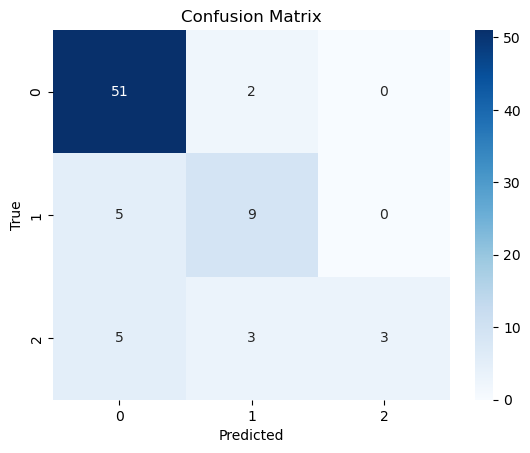

In [354]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Define the labels for the confusion matrix
labels = y_test['encoded_label'].unique()

true_label=y_test

#prediction=preds 
prediction= test_preds
# Create confusion matrix
cm = confusion_matrix(true_label,prediction, labels=labels)

# Create a dataframe from the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Create heatmap using Seaborn
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [355]:
test_preds

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0])

In [356]:
predicted_blinks= 0 
predicted_leftgaze = 0
predicted_rightgaze=0 
predicted_white = 0
sub_num = sub_number

if sub_num == '4' or sub_num =='8':
    folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's1/' + str(sub_num) + '_data_wordBlink.csv'
else:
    folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's0/' + str(sub_num) + '_data_wordBlink.csv'

df = pd.read_csv(folder_path)

# get input for model
X = pre_processed_data=pre_processing_Of_data_noDownsample(data_interest, cols_noDownsample)
featuered_data=get_features(pre_processed_data,4,cols_features)

featuered_data = featuered_data.drop(columns=['label'])
featuered_data = featuered_data.fillna(0)

# Make predictions
preds=model.predict(featuered_data)
preds = preds.squeeze()
print(preds)
for pred in preds:
    if pred == 0:
        predicted_blinks += 1
    elif pred == 1:
        predicted_leftgaze += 1
    elif pred == 2: 
        predicted_rightgaze += 1
    else:
        predicted_white += 1


# blink = 0, white = 3, gazeleft = 1, gazeright = 2

print('subject ' + str(sub_num))

print('blinks: ' +  str(predicted_blinks))
print('leftgaze: ' + str(predicted_leftgaze))
print('rightgaze: ' + str(predicted_rightgaze))
print('white: ' + str(predicted_white))

#print('----------------------------------------------')

/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_70069/2035454669.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_framee = pd.concat([data_framee, new_row], ignore_index=True)
/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_70069/2035454669.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_dataframe = pd.concat([features_dataframe, new_row], ignore_index=True)


[2 1 2 1 2 1 2 1 1 1 1 1 2 1 2 1 2 2 1 1 1 1 2 2 1 2 2 1 1 2 1 2 1 1 1 1 1
 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 2 1 1 2 1 2 1 2 1 1
 1 0 1 2 1 1 2 1 1 1 1 2 2 2 1 1 1 1 2 2 1 2 1 2 1 1 1 2 1 1 2 2 2 1 2 2 1
 1 0 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 2
 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 2 1 2 1 1 1 2 1 1
 2 1 2 1 1 2 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1
 1 1 1 1 2 1 1 2 1 2 1 2 1 1 1 0 1 2 1 1 2 1 1 1 1 2 2 1 1 1 1 1 2 2 1 2 1
 2 1 1 1 2 1 1 2 2 2 1 2 2 1 1 0 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 2 1 1 1 2 1 1 1 1 2 1 1 1 1 1 2 1 2 1 2 2 1 1 1]
subject 24
blinks: 4
leftgaze: 233
rightgaze: 87
white: 0


## Logistic Regression Model

In [357]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_val.mean()) 
X_test = X_test.fillna(X_test.mean()) 

model,preds=LogisticRegressionModel(X_train.values,y_train.values,X_val.values,y_val.values)

Mean Square Error: 0.7884615384615384
Accuracy : 0.6730769230769231


/opt/anaconda3/envs/EOG_classification/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [358]:
# Make predictions
train_preds=model.predict(X_train)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 

test_preds=model.predict(X_val)
print('val Accuracy :', metrics.accuracy_score(y_val, test_preds)) 

test_preds=model.predict(X_test)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 

train Accuracy : 0.711340206185567
val Accuracy : 0.6730769230769231
test Accuracy : 0.6923076923076923


/opt/anaconda3/envs/EOG_classification/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/EOG_classification/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/EOG_classification/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## KNN classfier

In [359]:
X_train

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
11,0.810616,0.000764,0.598552,0.121598,0.376280,0.000484,0.109070,0.643077,0.755402,0.000883,0.145336,0.828899,0.534629,0.000605,0.415372,0.463293,0.503603,0.001389,0.465984,0.853559
209,0.808268,0.000342,0.504713,0.075756,0.277702,0.000537,0.289039,0.172020,0.707343,0.003972,0.562681,0.116041,0.425867,0.032096,0.696231,0.036766,0.745764,0.055265,0.587120,0.017494
245,0.804074,0.001202,0.325257,0.119358,0.423529,0.000077,0.577286,0.116527,0.791590,0.000055,0.560451,0.042345,0.487096,0.000204,0.697624,0.033048,0.529840,0.000041,0.624946,0.024013
214,0.799143,0.001956,0.527624,0.101039,0.346258,0.000532,0.627044,0.287884,0.796378,0.004325,0.449557,0.031072,0.510759,0.047602,0.702369,0.035469,0.831048,0.073885,0.581055,0.010587
39,0.875386,0.001094,0.568676,0.142208,0.397192,0.000783,0.415972,0.461344,0.783735,0.000622,0.435957,0.547154,0.461542,0.000711,0.477021,0.232972,0.712925,0.002893,1.000000,0.568049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.816386,0.000640,0.308051,0.116194,0.446718,0.000398,0.510039,0.090369,0.679819,0.004896,0.437981,0.064940,0.357322,0.043320,0.696309,0.026509,0.456012,0.075353,0.546773,0.012613
210,0.839564,0.000273,0.257344,0.343957,0.415150,0.000524,0.362543,0.104297,0.783768,0.002926,0.525875,0.004547,0.750460,0.036866,0.687957,0.003339,0.323898,0.057996,0.560061,0.005732
229,0.830502,0.001048,0.242464,0.228886,0.429370,0.000392,0.511408,0.053926,0.782051,0.005160,0.389856,0.109921,0.450171,0.047528,0.737159,0.024493,0.671981,0.069776,0.616098,0.013455
185,0.819085,0.000329,0.581122,0.140143,0.443386,0.000294,0.713258,0.612657,0.804639,0.000473,0.553914,0.475047,0.497419,0.001738,0.287964,0.704464,0.532286,0.001756,0.382775,0.871132


In [360]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create a KNN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_val)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6538461538461539


/opt/anaconda3/envs/EOG_classification/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### PCA

In [361]:
import numpy as np
from sklearn.decomposition import PCA
# create a PCA object with two components
pca = PCA(n_components=10)

# fit the PCA model to the data and transform the data
Xtrain_pca = pca.fit_transform(X_train)
Xtest_pca=pca.transform(X_test)
# print the explained variance ratio of the two principal components
print(pca.explained_variance_ratio_)

[0.40373508 0.10999198 0.09614776 0.08616508 0.06907129 0.05625938
 0.05045884 0.03012705 0.02365632 0.02180983]


In [362]:
model,preds=LogisticRegressionModel(Xtrain_pca,y_train,Xtest_pca,y_test)

Mean Square Error: 0.7051282051282052
Accuracy : 0.6794871794871795


/opt/anaconda3/envs/EOG_classification/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [363]:
#after applaying pca
train_preds=model.predict(Xtrain_pca)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 
test_preds=model.predict(Xtest_pca)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 

train Accuracy : 0.7010309278350515
test Accuracy : 0.6794871794871795


In [328]:
# # Calculate correlation coefficient

# column1 = [0.639, 0.667, 0.694, 0.75, 0.528, 0.611, 0.722, 0.889, 0.611,  0.75, 0.639]
# column2 = [416, 236, 350, 518, 408, 14, 857, 241,879, 893, 131]
# column3 = [176, 0,0,78, 7, 5, 0,0,0,0,12]
# column4 = [0,0,0,18,0,436,0,52,25,0,0]

# r, _ = stats.pearsonr(column1, column4)

# # Number of data points
# n = len(column1)

# # Calculate t-statistic
# t_stat = r * np.sqrt((n - 2) / (1 - r**2))

# # Calculate p-value
# p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

# # Determine significance
# alpha = 0.05
# if p_value <= alpha:
#     print(f"Significant correlation (p-value = {p_value})")
# else:
#     print(f"No significant correlation (p-value = {p_value})")

# print(f"Correlation coefficient: {r}")

In [868]:
# task 1
import pandas as pd
import glob
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

predicted_blinks = 0
predicted_leftgaze = 0
predicted_rightgaze = 0

#sub_nums = [4,5,6,7,11,12,13,14,15,17,18,20,21,22,24]
#sub_nums = [4,5,7,11,12,15,17, 20,21,22,24]
sub_nums = [5,6, 7,8, 11,12,14, 15,17, 20, 21,24]

dataframes = []
for sub_num in sub_nums:
    # Define the folder path
    if sub_num == 4 or sub_num ==8:
        folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's1/blinkGazeStudy/EEG0_reformat'
    else:
        folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's0/blinkGazeStudy/EEG0_reformat'

    # Use glob to find all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

    # Initialize an empty list to hold the DataFrames

    # Loop through the list of CSV files and read each one into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        df["channel/polarity"] = "EOG0"
        new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
        df.columns = new_column_names
        dataframes.append(df)

    if sub_num == 4 or sub_num ==24:
        folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's1/blinkGazeStudy/EEG1_reformat'
    else:
        folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's0/blinkGazeStudy/EEG1_reformat'
    # Use glob to find all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

    # Loop through the list of CSV files and read each one into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        df["channel/polarity"] = "EEG0"
        new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
        df.columns = new_column_names
        dataframes.append(df)

    if sub_num == 4 or sub_num ==8:
        folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's1/blinkGazeStudy/EOG0_reformat'
    else:
        folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's0/blinkGazeStudy/EOG0_reformat'
    # Use glob to find all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

    # Loop through the list of CSV files and read each one into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        df["channel/polarity"] = "EEG1"
        new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
        df.columns = new_column_names
        dataframes.append(df)

# Concatenate all DataFrames into one big DataFrame
all_dataframe = pd.concat(dataframes, ignore_index=True)

In [869]:
#all_dataframe
# Define the labels of interest
#labels_of_interest = ['blinkLabel', 'gazeLeftLabel', 'gazeRightLabel', 'whiteLabel']
labels_of_interest = ['blinkLabel', 'gazeLeftLabel', 'gazeRightLabel', 'whiteLabel']
# Filter the DataFrame
data_interest = all_dataframe[all_dataframe['label'].isin(labels_of_interest)]
data_interest

,label,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,...,Sample241,Sample242,Sample243,Sample244,Sample245,Sample246,Sample247,Sample248,Sample249,Sample250
5,blinkLabel,590486.548025,590630.956363,591042.364702,590585.773040,590420.181379,590597.589717,590594.998056,590329.406394,590390.814733,...,586816.325518,586821.733857,587438.142195,588072.550534,586830.958872,586127.367211,586982.775549,588779.183888,587091.592227,EOG0
7,blinkLabel,582876.453106,583163.861444,584103.269783,582965.678121,582681.086460,582204.494798,584131.903137,583142.311476,582704.719814,...,578863.230599,579083.638938,580028.047276,579329.455615,577917.863953,578927.272292,579652.680630,579422.088969,578699.497308,EOG0
9,whiteLabel,575320.358187,576613.766525,576490.174864,575143.583202,575251.991541,575962.399879,576160.808218,573866.216557,574777.624895,...,571419.135680,571607.544019,571926.952357,571356.360696,571326.769034,571265.177373,570345.585712,571008.994050,571235.402389,EOG0
11,whiteLabel,567633.263268,568124.671606,567353.079945,567337.488283,567474.896622,567322.304961,566264.713299,567233.121638,567379.529976,...,563654.040761,564452.449100,564560.857438,563522.265777,562772.674115,563239.082454,564760.490793,563536.899131,563464.307470,EOG0
12,blinkLabel,564162.715808,565189.124147,563645.532485,563437.940824,563920.349163,565112.757501,563326.165840,562182.574178,563568.982517,...,559627.493302,560077.901640,559613.309979,559393.718317,559515.126656,559251.534995,558522.943333,559302.351672,559444.760010,EOG0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25161,gazeRightLabel,17621.489019,17772.269068,17689.049116,17602.829164,17514.609213,17402.389261,17304.169309,17228.949358,17165.729406,...,2564.572080,2505.352128,2446.132176,2382.912225,2288.692273,2214.472321,2184.252370,2147.032418,2090.812466,EEG1
25163,blinkLabel,-12754.303990,-12818.523942,-12864.743893,-12878.963845,-12932.183797,-12994.403748,-13055.623700,-13135.843652,-13210.063603,...,-11739.220930,-11357.440882,-11511.660833,-11602.880785,-11600.100737,-11600.320688,-11655.540640,-11519.760592,-11310.980543,EEG1
25165,gazeLeftLabel,-4348.097000,-4311.316951,-4207.536903,-4174.756855,-3985.976806,-2851.795308,-3140.015259,-3228.235211,-3405.455163,...,2479.986061,2594.766109,2626.546157,2881.326206,2874.106254,2721.886302,2725.666351,2609.446399,2515.226447,EEG1
25167,blinkLabel,10014.109991,9929.890039,10026.670088,9965.450136,9817.230184,9971.010233,10190.790281,10494.570329,10048.350378,...,16364.193051,16323.973099,16564.753148,16597.533196,16515.313244,16771.093293,17029.873341,16601.653389,16495.433438,EEG1


In [870]:
data = data_interest

# pre processing
cols = ["label"] + [f"sample{i}" for i in range(50)]
data= data.iloc[:, 0:251]
pre_processed_data=pre_processing_Of_data_noDownsample(data, cols_noDownsample)

# feature extraction
cols_features = ["label"] + [f"col{i}" for i in range(20)]
featuered_data=get_features(pre_processed_data,4,cols_features)

# label encoding
df=featuered_data
encoded_Data=df

#label enconding for y

df = featuered_data

le = LabelEncoder()

df['encoded_label'] = le.fit_transform(df['label'])
df = df.drop(["label"], axis=1)
encoded_Data=df

# preparing data
X=encoded_Data.drop(["encoded_label"],axis=1)
X=featureScalling(X)
y=encoded_Data[["encoded_label"]]
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.4, random_state=40,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=40,stratify=y_dev)

model, preds=random_forest(X_train,y_train,X_val,y_val)



/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_78654/2035454669.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_framee = pd.concat([data_framee, new_row], ignore_index=True)
/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_78654/2035454669.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_dataframe = pd.concat([features_dataframe, new_row], ignore_index=True)
/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarn

Accuracy : 0.5770423991726991


In [871]:
test_preds=model.predict(X_test)
test_prob = model.predict_proba(X_test)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 
# Evaluate the model on the testing set
accuracy = accuracy_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
# auc = roc_auc_score(y_test, test_prob, multi_class='ovr')
report = classification_report(y_test, test_preds)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
# print(f'AUC: {auc:.2f}')
print('Classification Report:\n', report)

test Accuracy : 0.5796277145811789
Accuracy: 0.58
F1-score: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.47       685
           1       1.00      0.17      0.28       151
           2       0.94      0.12      0.22       136
           3       0.57      0.85      0.68       962

    accuracy                           0.58      1934
   macro avg       0.77      0.38      0.41      1934
weighted avg       0.63      0.58      0.54      1934



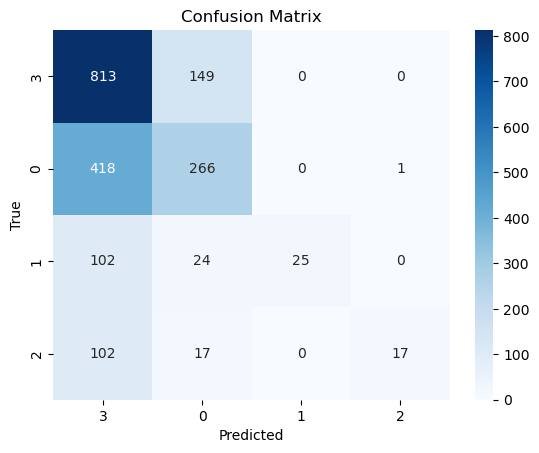

In [872]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Define the labels for the confusion matrix
labels = y_test['encoded_label'].unique()

true_label=y_test

#prediction=preds 
prediction= test_preds
# Create confusion matrix
cm = confusion_matrix(true_label,prediction, labels=labels)

# Create a dataframe from the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Create heatmap using Seaborn
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [608]:
from sklearn.preprocessing import StandardScaler

predicted_blinks = 0
predicted_leftgaze = 0
predicted_rightgaze = 0

#sub_nums = [4,5,6,7,11,12,13,14,15,17,18,20,21,22,24]
#sub_nums = [4,5,7,11,12,15,17, 20,21,22,24]
sub_nums = [5,6, 7,8, 11,12,14, 15,17, 20, 21,24]

# Initialize lists to store train and test data
train_data = []
test_data = []

for sub_num in sub_nums:
    # Define the folder path for EEG0 data
    folder_path = f'data_BlinkGaze/sub{sub_num}s0/blinkGazeStudy/EEG0_reformat'
    # Use glob to find all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

    # Loop through the list of CSV files and read each one into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        df["channel/polarity"] = "EOG0"
        new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
        df.columns = new_column_names
        # Split data into train and test
        train, test = train_test_split(df, test_size=0.4, random_state=40)
        train_data.append(train)
        test_data.append(test)

    # Define the folder path for EEG1 data
    folder_path = f'data_BlinkGaze/sub{sub_num}s0/blinkGazeStudy/EEG1_reformat'
    # Use glob to find all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

    # Loop through the list of CSV files and read each one into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        df["channel/polarity"] = "EEG0"
        new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
        df.columns = new_column_names
        # Split data into train and test
        train, test = train_test_split(df, test_size=0.4, random_state=40)
        train_data.append(train)
        test_data.append(test)

    # Define the folder path for EOG0 data
    folder_path = f'data_BlinkGaze/sub{sub_num}s0/blinkGazeStudy/EOG0_reformat'
    # Use glob to find all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

    # Loop through the list of CSV files and read each one into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        df["channel/polarity"] = "EEG1"
        new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
        df.columns = new_column_names
        # Split data into train and test
        train, test = train_test_split(df, test_size=0.4, random_state=40)
        train_data.append(train)
        test_data.append(test)

# Concatenate all train and test DataFrames into one big DataFrame
train_dataframe = pd.concat(train_data, ignore_index=True)
test_dataframe = pd.concat(test_data, ignore_index=True)

# Define the labels of interest
labels_of_interest = ['blinkLabel', 'gazeLeftLabel', 'gazeRightLabel']

# Filter the DataFrames
train_data_interest = train_dataframe[train_dataframe['label'].isin(labels_of_interest)]
test_data_interest = test_dataframe[test_dataframe['label'].isin(labels_of_interest)]

# Use only necessary columns for pre-processing
train_data = train_data_interest.iloc[:, 0:251]
test_data = test_data_interest.iloc[:, 0:251]

# Pre-
cols = ["label"] + [f"sample{i}" for i in range(50)]
cols_noDownsample = ["label"] + [f"sample{i}" for i in range(250)]
train_data = pre_processing_Of_data_noDownsample(train_data,cols_noDownsample)
test_data = pre_processing_Of_data_noDownsample(test_data, cols_noDownsample)

# Feature extraction

cols_features = ["label"] + [f"col{i}" for i in range(20)]
train_data = get_features(train_data, 4, cols_features)
test_data = get_features(test_data, 4, cols_features)

# Label encoding
label_encoder = LabelEncoder()
train_data['encoded_label'] = label_encoder.fit_transform(train_data['label'])
train_data = train_data.drop(["label"], axis=1)
test_data['encoded_label'] = label_encoder.transform(test_data['label'])
test_data = test_data.drop(["label"], axis=1)

# Split features and labels
X_train = train_data.drop(["encoded_label"], axis=1)
y_train = train_data[["encoded_label"]]
X_test = test_data.drop(["encoded_label"], axis=1)
y_test = test_data[["encoded_label"]]

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model, preds = random_forest(X_train, y_train.values.ravel(), X_test, y_test)

# Evaluate the model on the testing set
test_preds = model.predict(X_test)
print('Test Accuracy :', accuracy_score(y_test, test_preds)) 
# Calculate metrics
accuracy = accuracy_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds, average='weighted')
report = classification_report(y_test, test_preds)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
print('Classification Report:\n', report)

# Report test accuracies for each subject
subject_test_accuracies = {}

for sub_num in sub_nums:
    # Filter test data for the current subject
    subject_test_data = test_data_interest[test_data_interest['subject'] == sub_num]

    # Use only necessary columns for pre-processing
    subject_test_data_processed = subject_test_data.iloc[:, 0:251]

    # Pre-processing
    subject_test_data_processed = pre_processing_Of_data_noDownsample(subject_test_data_processed, cols=None)

    # Feature extraction
    subject_test_data_processed

/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_78654/2035454669.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_framee = pd.concat([data_framee, new_row], ignore_index=True)
/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_78654/2035454669.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_framee = pd.concat([data_framee, new_row], ignore_index=True)
/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_78654/2035454669.py:75: FutureWarning: The behavi

Accuracy : 0.7389162561576355
Test Accuracy : 0.7389162561576355
Accuracy: 0.74
F1-score: 0.67
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86      1395
           1       0.18      0.05      0.08       240
           2       0.12      0.02      0.04       192

    accuracy                           0.74      1827
   macro avg       0.36      0.34      0.32      1827
weighted avg       0.63      0.74      0.67      1827



KeyError: 'subject'